In [1]:
import networkx as nx


In [2]:
with open("ahrrefs-edges.txt","r") as f:
    edges = f.readlines() 

In [3]:
def build_graph(edges,self_loop=False):
    G = nx.DiGraph()
    for e in edges:
        e = list(map(lambda x:int(x),e.strip().strip("\n").split("\t")))
        G.add_edge(e[0],e[1])
    if not self_loop:
        G.remove_edges_from(nx.selfloop_edges(G))
    return G

In [4]:
G = build_graph(edges)

In [5]:
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 749313 nodes and 2683078 edges


In [11]:
nx.number_strongly_connected_components(G)

701938

## Prune Graph using K-Cores

In [7]:
subgraph = nx.k_core(G, k=5)

In [8]:
print(f"Pruned graph has {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges")

Pruned graph has 124081 nodes and 1719338 edges


## Applying node2vec to pruned graph

In [9]:
from node2vec import Node2Vec

In [10]:
## Configurations
d = 64
walk_length = 80
num_walks = 100
context_size = 10
p = 1
q = 1

In [11]:
node2vec = Node2Vec(subgraph,
                    dimensions=d,
                    walk_length=walk_length,
                    num_walks=num_walks,
                    workers=4,
                    temp_folder="/mnt/data/")

Computing transition probabilities:  15%|█▌        | 18720/124081 [34:07<3:12:03,  9.14it/s]


KeyboardInterrupt: 

In [ ]:
model = node2vec.fit(window=context_size)
model.save("model_5.bin")

### Compressing Features to 2D space and plotting them

In [6]:
import gensim
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [8]:
model = gensim.models.Word2Vec.load("model_5.bin")

In [9]:
nodes = [x for x in model.wv.vocab]
embeddings = np.array([model.wv[x] for x in nodes])

In [11]:
len(nodes)

124081

In [20]:
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)

In [14]:
colors = {
    "evd": "tomato",
    "ahrref": "deepskyblue"
}
def node_type(node):
    return "evd" if node<=871 else "ahrref"

In [15]:
nodes.sort(key=lambda x: node_type(int(x)))
node_colors = [colors[node_type(int(x))] for x in nodes ]

In [16]:
def build_graph(coordinates,node_colors=[],group_colors={}, savefig=False, f="test.png"):
    figure = plt.figure(figsize=(11, 9))

    ax = figure.add_subplot(111)

    ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=node_colors)

    patches = [mpatches.Patch(color=color, label=node_type) for node_type, color in group_colors.items()]
    ax.legend(handles=patches)
    if savefig:
        plt.savefig(f)



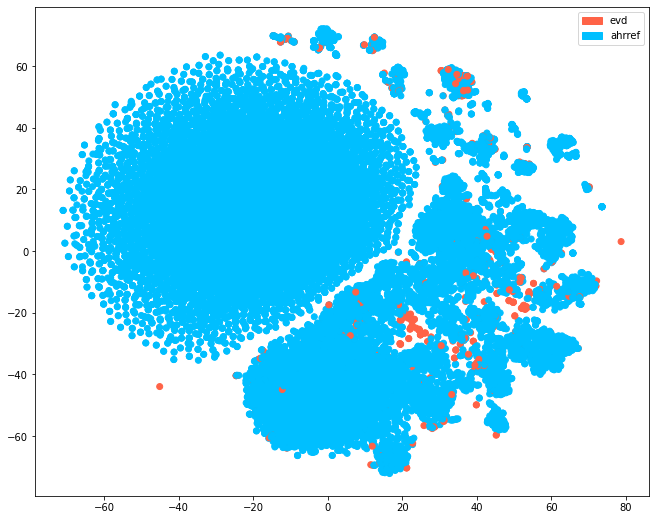

In [46]:
build_graph(embeddings_2d, node_colors, colors)

## Computing DBScan to find clusters within this

In [18]:
from sklearn.cluster import DBSCAN

In [19]:
db = DBSCAN(eps=0.3, min_samples=10).fit(embeddings)